In [1]:
# Referred Notebook: https://www.kaggle.com/rajmehra03/a-comprehensive-guide-to-transfer-learning

In [2]:
#pip install seaborn

In [3]:
#pip install opencv-python

In [4]:
#pip install tqdm

In [5]:
#pip install Pillow

In [6]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
X=[] #images array
Z=[] #labels array

IMG_SIZE=40

#path variables
daisy = 'flowers/daisy'
sunflower = 'flowers/sunflower'
tulip ='flowers/tulip'
dandelion ='flowers/dandelion'
rose ='flowers/rose'

In [8]:
def assign_label(img,flower_type):
    return flower_type

In [9]:
def make_train_data(flower_type, directory):
    for img in tqdm(os.listdir(directory)):
        try:
            label=assign_label(img,flower_type)
            path = os.path.join(directory,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img))
            Z.append(str(label))
        except Exception as e:
            print("One bad image format found. Omitting this picture. \n\n", str(e))

In [10]:
make_train_data('Daisy',daisy)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 769/769 [00:04<00:00, 156.76it/s]

769


In [11]:
make_train_data('Sunflower',sunflower)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 734/734 [00:09<00:00, 76.62it/s]

1503


In [12]:
make_train_data('Tulip',tulip)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 984/984 [00:09<00:00, 99.17it/s]

2487


In [13]:
make_train_data('Dandelion',dandelion)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:11<00:00, 89.82it/s]

One bad image format found. Omitting this picture. 

 OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

One bad image format found. Omitting this picture. 

 OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

One bad image format found. Omitting this picture. 

 OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

3539


In [14]:
make_train_data('Rose',rose)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 784/784 [00:06<00:00, 116.04it/s]

4323


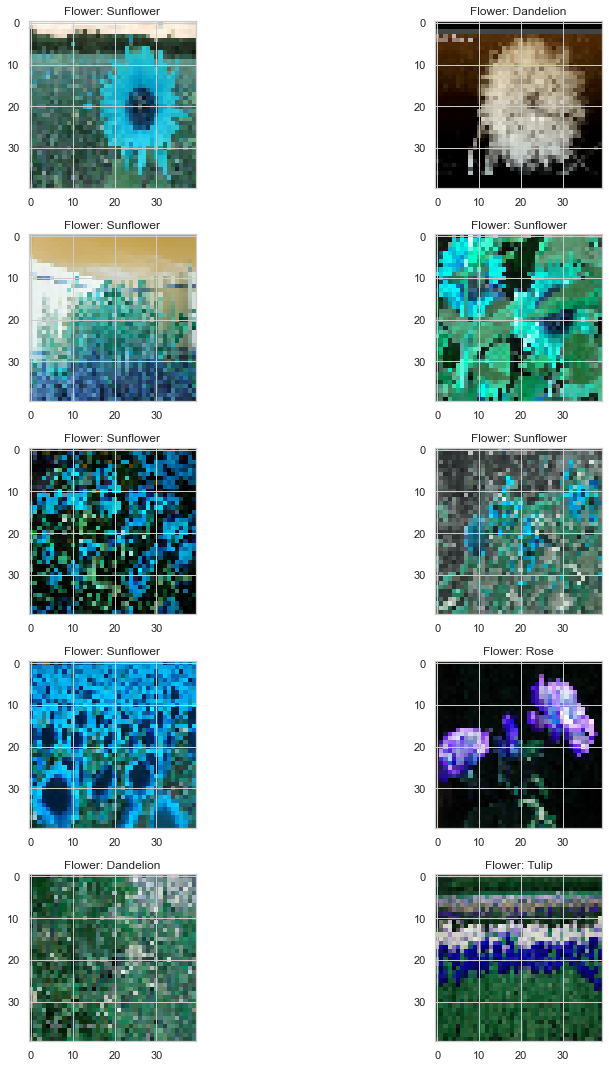

In [15]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [16]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [18]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [19]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(40,40,3), pooling='avg')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 40, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 40, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 20, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 20, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 20, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 128)       0     

In [21]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [23]:
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train last two layers of vgg16
for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False

In [26]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


In [27]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 15, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/15
25/25 [==============================] - 228s 9s/step - loss: 1.1254 - accuracy: 0.5514 - val_loss: 0.9099 - val_accuracy: 0.6475
Epoch 2/15
25/25 [==============================] - 188s 8s/step - loss: 0.7755 - accuracy: 0.7065 - val_loss: 0.7401 - val_accuracy: 0.7160
Epoch 3/15
25/25 [==============================] - 159s 6s/step - loss: 0.6591 - accuracy: 0.7450 - val_loss: 0.7249 - val_accuracy: 0.7299
Epoch 4/15
25/25 [==============================] - 157s 6s/step - loss: 0.6281 - accuracy: 0.7669 - val_loss: 0.7559 - val_accuracy: 0.6947
Epoch 5/15
25/25 [==============================] - 156s 6s/step - loss: 0.5782 - accuracy: 0.7847 - val_loss: 0.6776 - val_accuracy: 0.7382
Epoch 6/15
25/25 [==============================] - 167s 7s/step - loss: 0.5164 - accuracy: 0.8094 - val_loss: 0.6784 - val_accuracy: 0.7317
Epoch 7/15
25/25 [==============================] - 173s 7s/step - loss: 0.4794 - accuracy: 0.8194 - val_loss: 0.6594 - val_accuracy: 0.7697
Epoch 8/15
25

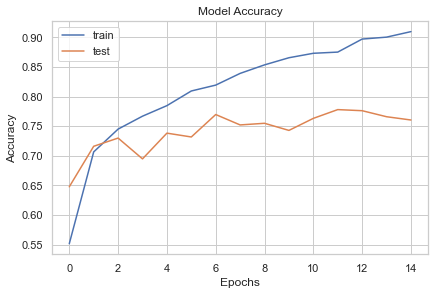

In [28]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

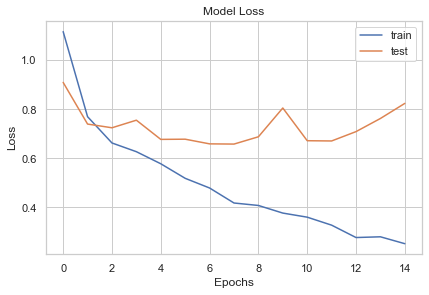

In [29]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [30]:
from keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input

In [31]:
def cam(img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

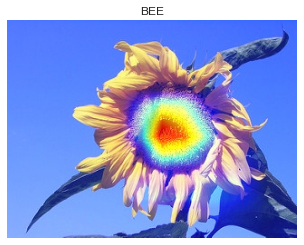

In [32]:
cam('flowers/sunflower/151898652_b5f1c70b98_n.jpg')